In [1]:

import lightkurve as lk
import matplotlib.pyplot as plt
import os
import glob

#this is used to create a dynamic window length later for flattening
def get_number_of_days(lightcurve):
    time = lightcurve.time
    number_of_days = (time.max() - time.min()).value  # Convert to days
    return number_of_days

#run the tess_data_handler.py script to get data and copy to this folder
#this test data needs to be within jupyter_tests
tic_id = 261136679
star_directory = f"TIC_{tic_id}"
print(star_directory)

#gives a list of all .fits files for this star
base_dir = os.path.join(os.getcwd(), "data", "TESS_Downloads", star_directory)
fits_files = glob.glob(os.path.join(base_dir, '**', '*_lc.fits'), recursive=True)
print(base_dir)
print(fits_files)



TIC_261136679
/home/preston/Desktop/Exoplanet-Hunt/Jupyter_tests/data/TESS_Downloads/TIC_261136679
['/home/preston/Desktop/Exoplanet-Hunt/Jupyter_tests/data/TESS_Downloads/TIC_261136679/mastDownload/TESS/tess2023153011303-s0066-0000000261136679-0260-s/tess2023153011303-s0066-0000000261136679-0260-s_lc.fits', '/home/preston/Desktop/Exoplanet-Hunt/Jupyter_tests/data/TESS_Downloads/TIC_261136679/mastDownload/TESS/tess2021014023720-s0034-0000000261136679-0204-s/tess2021014023720-s0034-0000000261136679-0204-s_lc.fits', '/home/preston/Desktop/Exoplanet-Hunt/Jupyter_tests/data/TESS_Downloads/TIC_261136679/mastDownload/TESS/tess2021146024351-s0039-0000000261136679-0210-s/tess2021146024351-s0039-0000000261136679-0210-s_lc.fits', '/home/preston/Desktop/Exoplanet-Hunt/Jupyter_tests/data/TESS_Downloads/TIC_261136679/mastDownload/TESS/tess2023018032328-s0061-0000000261136679-0250-s/tess2023018032328-s0061-0000000261136679-0250-s_lc.fits', '/home/preston/Desktop/Exoplanet-Hunt/Jupyter_tests/data/TES

/home/preston/Desktop/Exoplanet-Hunt/Jupyter_tests/data/TESS_Downloads/TIC_261136679/mastDownload/TESS/tess2023043185947-s0062-0000000261136679-0254-s/tess2023043185947-s0062-0000000261136679-0254-s_lc.fits


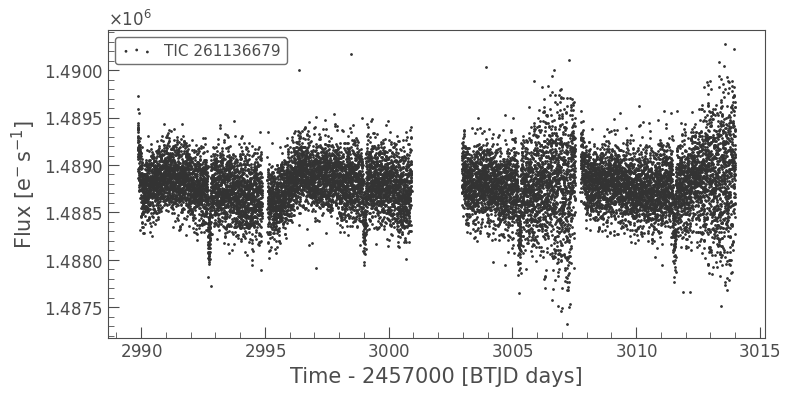

In [18]:
#specify which dataset to use
#(tested with file 0,1,2,3,4 & works well)
lc_path = fits_files[11]
print(lc_path)
lc = lk.read(lc_path)

#this is our raw light curve
lc.scatter()
plt.show()

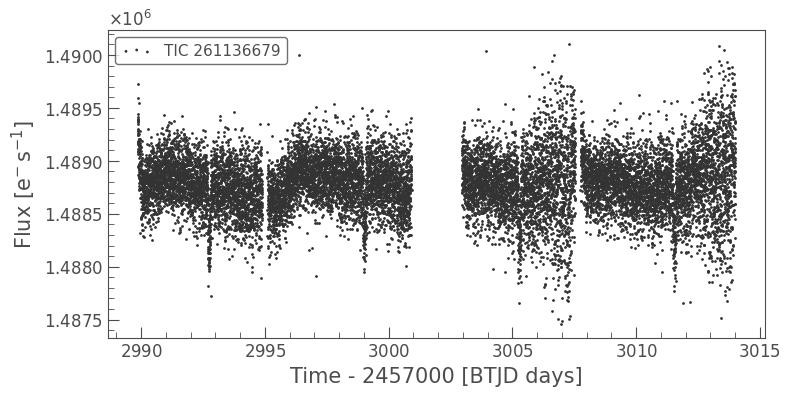

In [19]:
#refine the light curve by removing bad data
lc = lc.remove_nans().remove_outliers()
lc.scatter()
plt.show()

24


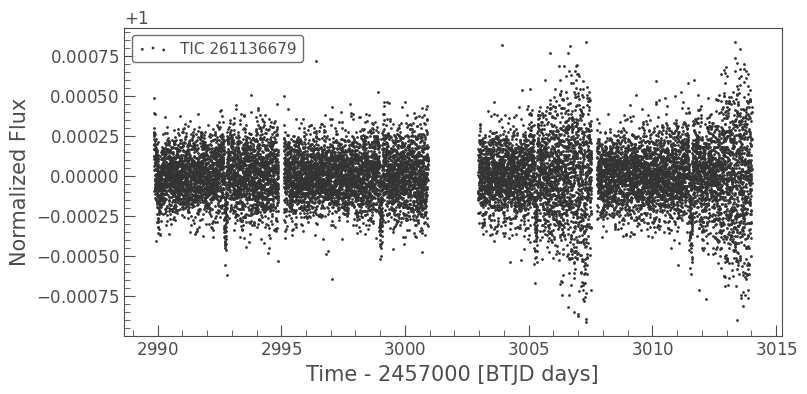

In [20]:
#the flatten function needs a set window, otherwise it may erase transit signals
observation_time = int(get_number_of_days(lc))
print(observation_time)
dynamic_window = observation_time*30

#flattened data
flat_lc = lc.flatten(window_length=dynamic_window)
flat_lc.scatter()
plt.show()

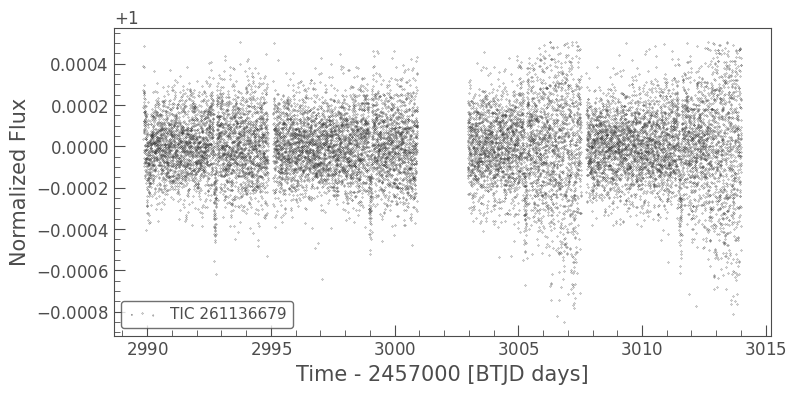

In [21]:
flatclip_lc = flat_lc.remove_outliers(sigma_upper=3,sigma_lower=5)
flatclip_lc.scatter(s=0.2)
plt.show()

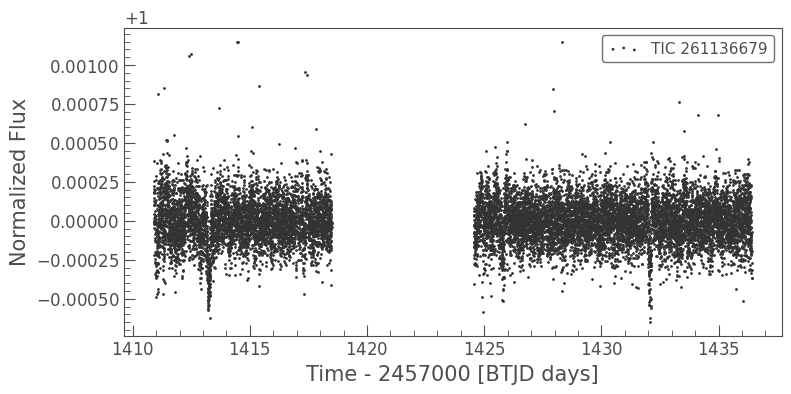

In [6]:
#WAIT: this step may not be needed for good data
#should a mask be needed for data, manually create one here
jd_time = flat_lc.time.jd
mask = ((jd_time < (2457000+1420)) | (jd_time > (2457000+1424)))&((jd_time < (2457000+1346)) | (jd_time > (2457000+1350)))
masked_lc = flat_lc[mask]

masked_lc.scatter()
plt.show()

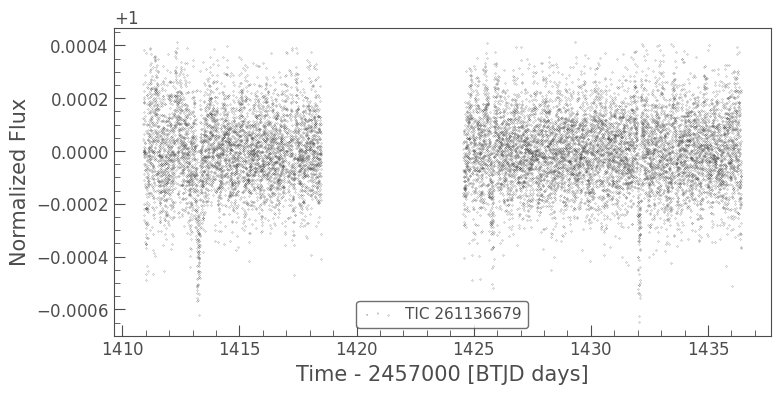

In [7]:
#clipping masked data if used
clipped_lc = masked_lc.remove_outliers(sigma_upper=3,sigma_lower=5)
clipped_lc.scatter(s=0.1)
plt.show()

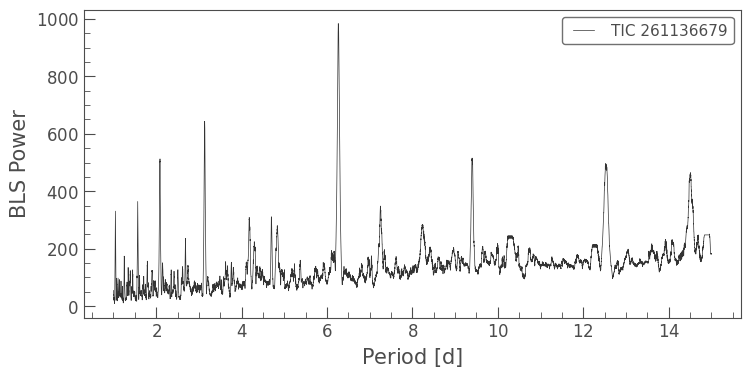

In [22]:
#assuming no mask was used, periodogram will find periodicity in possible transit
import numpy as np
periodogram = flatclip_lc.to_periodogram(method='bls', period=np.arange(1, 15, 0.001))
periodogram.plot()
plt.show()

Best fit period: 6.26400 d


/home/preston/Desktop/Exoplanet-Hunt/exoplanet-env/lib/python3.10/site-packages/astropy/utils/decorators.py:603: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


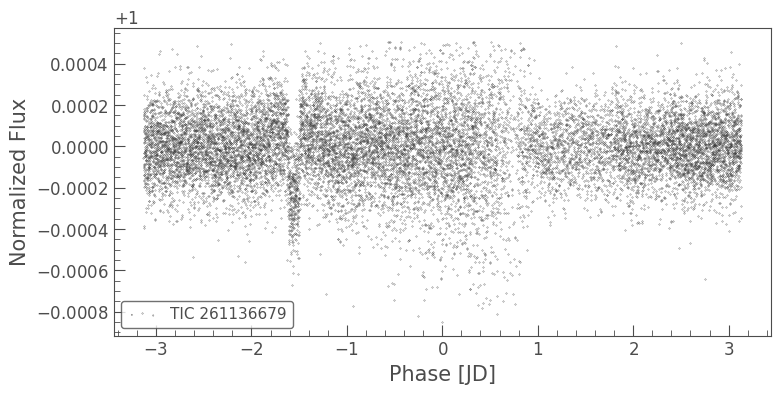

In [24]:
#using the peak of the periodogram to fold the light curve
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.5f}'.format(best_fit_period))

#an attempt to center the transit even at 0 phase. Will not always work.(like file 11)
t0 = flatclip_lc.time[np.argmin(flatclip_lc.flux)]

folded_lc = flatclip_lc.fold(best_fit_period, t0=t0)
folded_lc.scatter(s=0.2)
plt.show()

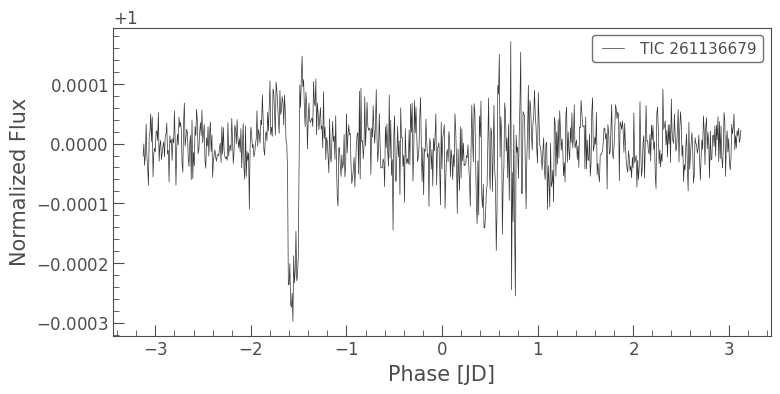

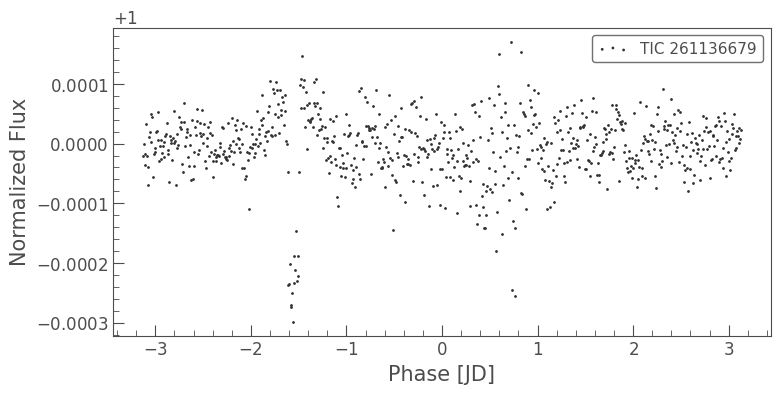

In [25]:
#sometimes binning can help to see the data better
binned_lc = folded_lc.bin(time_bin_size=0.008)
binned_lc.plot()
binned_lc.scatter()
#plt.ylim([min(binned_lc.flux) - 0.001, max(binned_lc.flux) + 0.001])
plt.show()